# 1. Data Preparation

## 1.1 Load Data

In [79]:
import pandas as pd
import numpy as np
import os
os.chdir("C:/Users/TonyG/Documents/GitHub/bads/kaggle")

### Load known and unknown data

In [80]:
data = pd.read_csv("./data/BADS_WS2021_known.csv", sep = ",", index_col='order_item_id')
og_data = data.copy()

data_u = pd.read_csv("./data/BADS_WS2021_unknown.csv", sep = ",", index_col='order_item_id')
og_data_u = data_u.copy()

Change datatype of date variables to datetime, target to bool and category variables to category

In [81]:
filter_date = ["order_date", "user_reg_date", "delivery_date", "user_dob"] # filter for variables to be changed to datetime
data[filter_date] = data[filter_date].apply(pd.to_datetime,format = "%Y-%m-%d") # change variables type to datetime

filter_cat = ["item_size", "item_color", "user_title", "user_state"] # filter for variables to be changed to category
data[filter_cat] = data[filter_cat].astype("category") # change variables type to category

data["return"] = data["return"].astype(bool) # Change return type to bool

# Repeat exercise for unknown data set
data_u[filter_date] = data_u[filter_date].apply(pd.to_datetime,format = "%Y-%m-%d")
data_u[filter_cat] = data_u[filter_cat].astype("category")

## Unify categories for item_size and item_color between unknown and known data set otherwise won't work with XGBoost. 

Unification for known dataset, for unknown see below.

In [82]:
union_size = data["item_size"].cat.categories.sort_values().intersection(data_u["item_size"].cat.categories.sort_values()) # Get the union of all sizes from both datasets
union_col = data["item_color"].cat.categories.sort_values().intersection(data_u["item_color"].cat.categories.sort_values()) # Get the union of all colors from both datasets


difference_known = data["item_size"].cat.categories.sort_values().difference(union_size)

if len(difference_known) > 0:
    data["item_size"] = np.where(data['item_size'].isin(difference_known), 'Difference', data['item_size'])
    data["item_size"] = data["item_size"].astype("category")
    print("Known sizes unified.")
else: 
    data["item_size"].cat.add_categories("Difference", inplace = True)
    print("No known sizes to unify.")

difference_known = data["item_color"].cat.categories.sort_values().difference(union_col)

if len(difference_known) > 0:
    data["item_color"] = np.where(data['item_color'].isin(difference_known), 'Difference', data['item_color'])
    data["item_color"] = data["item_color"].astype("category")
    print("Known colors unified.")
else:
    data["item_color"].cat.add_categories("Difference", inplace = True)
    print("No known color to unify.")

Known sizes unified.
Known colors unified.


In [83]:
# Unknown Data set

difference_unknown = data_u["item_size"].cat.categories.sort_values().difference(union_size)

if len(difference_unknown) > 0:
    data_u["item_size"] = np.where(data_u['item_size'].isin(difference_unknown), 'Difference', data_u['item_size'])
    data_u["item_size"] = data_u["item_size"].astype("category")
    print("Unknown sizes unified.")
else:
    data_u["item_size"].cat.add_categories("Difference", inplace = True)
    print("No unknown sizes to unify.")

difference_unknown = data_u["item_color"].cat.categories.sort_values().difference(union_col)

if len(difference_unknown) > 0:
    data_u["item_color"] = np.where(data_u['item_color'].isin(difference_unknown), 'Difference', data_u['item_color'])
    data_u["item_color"] = data_u["item_color"].astype("category")
    print("Unknown color unified.")
else:
    data_u["item_color"].cat.add_categories("Difference", inplace = True)
    print("No unknown colors to unify.")

Unknown sizes unified.
No unknown colors to unify.


### Feature selection for the variables item_size and item_color

First we coerse all categories of item_size together where the return ratio is either $\mathbb{P}$-a.s. False or True. 

In [84]:
help1 = pd.crosstab(data.item_size, data["return"]).apply(lambda r: r/r.sum(), axis=1)
size_f, size_t = help1[help1[0] == 1], help1[help1[1] == 1] # Item sizes where return is either 0 or 1

if len(size_f.index) > 0 or len(size_t.index) > 0:
    data["item_size"] = np.where(data['item_size'].isin(size_t.index), 'Other_true', data['item_size']) # Coerce to new category
    data["item_size"] = np.where(data['item_size'].isin(size_f.index), 'Other_false', data['item_size'])

    # Repeat for unknown data set but only use categories identified in the known data set
    data_u["item_size"] = np.where(data_u['item_size'].isin(size_t.index), 'Other_true', data_u['item_size']) # Coerce to new category
    data_u["item_size"] = np.where(data_u['item_size'].isin(size_f.index), 'Other_false', data_u['item_size'])
    print("Categories merged.")
else:
    print("No uninformative categories.")

Categories merged.


We do the same for the variable item_color

In [85]:
help1 = pd.crosstab(data.item_color, data["return"]).apply(lambda r: r/r.sum(), axis=1)
color_f, color_t = help1[help1[0] == 1], help1[help1[1] == 1] # Item sizes where return is either 0 or 1

if len(color_f.index) > 0 or len(color_t.index) > 0:
    data["item_color"] = np.where(data['item_color'].isin(color_t.index), 'Other_true', data['item_color']) # Coerce to new category
    data["item_color"] = np.where(data['item_color'].isin(color_f.index), 'Other_false', data['item_color'])
    
    # Repeat for unknown data set but only use categories identified in the known data set
    data_u["item_color"] = np.where(data_u['item_color'].isin(color_t.index), 'Other_true', data_u['item_color']) # Coerce to new category
    data_u["item_color"] = np.where(data_u['item_color'].isin(color_f.index), 'Other_false', data_u['item_color'])
    print("Categories merged.")
else:
    print("No uninformative categories.")

data[filter_cat] = data[filter_cat].astype("category")
data_u[filter_cat] = data_u[filter_cat].astype("category")

No uninformative categories.


Next we coerce categories by their difference in true to false ratio w.r.t. to the boolean return. Our initial threshold is 0.01 so 1%

In [86]:
help2 = pd.crosstab(data.item_size, data["return"]).apply(lambda r: r/r.sum(), axis=1)

threshold_percent = 0.05
series = pd.value_counts(data['item_size'])
mask = (help2[0]-help2[1]).abs().lt(threshold_percent)
data["item_size"] = np.where(data['item_size'].isin(series[mask].index), 'Other', data['item_size'])
data_u["item_size"] = np.where(data_u['item_size'].isin(series[mask].index), 'Other', data_u['item_size'])

data[filter_cat] = data[filter_cat].astype("category")
data_u[filter_cat] = data_u[filter_cat].astype("category")

Same for item_color

In [87]:
help2 = pd.crosstab(data.item_color, data["return"]).apply(lambda r: r/r.sum(), axis=1)

threshold_percent = 0.05
series = pd.value_counts(data['item_color'])
mask = (help2[0]-help2[1]).abs().lt(threshold_percent)
data["item_color"] = np.where(data['item_color'].isin(series[mask].index), 'Other', data['item_color'])
data_u["item_color"] = np.where(data_u['item_color'].isin(series[mask].index), 'Other', data_u['item_color'])

data[filter_cat] = data[filter_cat].astype("category")
data_u[filter_cat] = data_u[filter_cat].astype("category")

Compare new category levels with old category levels

In [88]:
og_data[filter_cat] = og_data[filter_cat].astype("category")
og_data_u[filter_cat] = og_data_u[filter_cat].astype("category")

# First unknown, then known, difference of categories
og_data_u.loc[:, ["item_size", "item_color"]].nunique()-data_u.loc[:, ["item_size", "item_color"]].nunique(), og_data.loc[:, ["item_size", "item_color"]].nunique()-data.loc[:, ["item_size", "item_color"]].nunique()

(item_size     31
 item_color    10
 dtype: int64,
 item_size     30
 item_color    19
 dtype: int64)

In [89]:
# Remaining number of categories
data.loc[:, ["item_size", "item_color"]].nunique(), data_u.loc[:, ["item_size", "item_color"]].nunique()

(item_size     72
 item_color    58
 dtype: int64,
 item_size     72
 item_color    57
 dtype: int64)

### Create Time_to_delivery

After some exploration we identified an irregular entry of delivery dates. The date "1994-12-31" showed up in 983 rows but the earliest order date is not befor 2007. Hence, some data must have been corrupted so that this date was hard coded into the data set instead of a missing value. We cannot determine the concrete reason for this (e.g. item wasn't delivered, delivery date could not be tracked) and for this reason we dropped the 983 observations from our dataset. For the protocol the return ration for those entries was 1/3 for 0.

In [90]:
data = data[data["delivery_date"] != "1994-12-31"]

In [91]:
from datetime import datetime
data["time_to_delivery"] = (data["delivery_date"]-data["order_date"]).dt.days

### Convert birth date to age in days

In [92]:
t1 = data["user_dob"]
t2 = datetime.now()

data["user_age"] = (t2-t1).dt.days

### Convert date of register to customer age in days

In [93]:
t1 = data["user_reg_date"]
t2 = datetime.now()

data["customer_age"] = (t2-t1).dt.days

In [94]:
# Repeat for unknown data
data_u["time_to_delivery"] = (data_u["delivery_date"]-data_u["order_date"]).dt.days

t1 = data_u["user_dob"]
t2 = datetime.now()

data_u["user_age"] = (t2-t1).dt.days

t1 = data_u["user_reg_date"]
t2 = datetime.now()

data_u["customer_age"] = (t2-t1).dt.days

data_u = data_u.drop(labels = ["order_date", "delivery_date", "user_dob", "user_reg_date"], axis = 1)

### Delete old date variables

In [95]:
backup = data.copy()
data = data.drop(labels = ["order_date", "delivery_date", "user_dob", "user_reg_date"], axis = 1)

Since there are still many categories left, we employ a different feature selection method, namely tree-based feature selection based on feature importance. Since feature importance is in line with our model (boosted trees) we think this method is well suited to provide a meaningful feature selection.
However, in order to select features at all we need to dummy encode the variables. Since we're mainly interested in feature selection for categories of the variables item_size and item_color, we drop all other variables, except the target variable return.

In [96]:
%%script false --no-raise-error
backup = data.copy()
backup_u = data_u.copy()

dummies = pd.get_dummies(data.loc[:, ["item_size", "item_color"]])
dummies_u = pd.get_dummies(data_u.loc[:, ["item_size", "item_color"]])
backup = backup.drop(labels = data.columns[:-1], axis = 1)
backup_u = backup_u.drop(labels = data_u.columns[:-1], axis = 1)
backup = pd.concat([backup, dummies], axis = 1)
backup_u = pd.concat([backup_u, dummies_u], axis = 1)

data_fs = backup
data_u_fs = backup_u

Couldn't find program: 'false'


In [97]:
backup = data.copy()
backup_u = data_u.copy()

dummies = pd.get_dummies(data.select_dtypes("category"))
dummies_u = pd.get_dummies(data_u.select_dtypes("category"))
backup = backup.drop(labels = data.select_dtypes("category").columns, axis = 1)
backup_u = backup_u.drop(labels = data_u.select_dtypes("category").columns, axis = 1)
backup = pd.concat([backup, dummies], axis = 1)
backup_u = pd.concat([backup_u, dummies_u], axis = 1)

data_fs = backup
data_u_fs = backup_u

Now we fit the tree classifier and select the feature by variable importance. Since we don't know the response for the unknown data set, we just select the same features.

In [98]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

X, y = data_fs.drop(labels = ["return", "time_to_delivery", "user_age"], axis = 1), data_fs.loc[:, "return"]
clf = ExtraTreesClassifier(n_estimators=100)
clf = clf.fit(X, y)
feat_selec = pd.DataFrame(data = np.array([clf.feature_importances_, X.columns]).transpose(), columns = ["Importance", "Feature"])
feat_selec.sort_values(by = "Importance", ascending = 0) # Sorted by importance

,Importance,Feature
3,0.192759,user_id
0,0.13511,item_id
4,0.13411,customer_age
2,0.126966,item_price
1,0.093037,brand_id
...,...,...
48,0.000051,item_size_45+
80,0.000048,item_color_almond
106,0.000045,item_color_ebony
16,0.000039,item_size_176


Now we select the best features based on quantiles of their feature importance, i.e. we select only the best 50%.

In [99]:
drop_vars = feat_selec[feat_selec["Importance"]<=feat_selec["Importance"].quantile(q = 0.5)].Feature
drop_vars

5                  item_size_1
7                item_size_100
8                item_size_104
9                item_size_116
10               item_size_128
                ...           
119           item_color_mango
129          item_color_silver
131         item_color_striped
135         user_title_Company
139    user_title_not reported
Name: Feature, Length: 78, dtype: object

This will be used later, when we finished the data transformation process, since it is easier to drop the dummies when we converted the data to only contain dummies for categorical data. 

Since there are still many categories we coerce all categories with less than 100 observations in it ($\approx 1\,603$ observations) to one category, namely "other". 

In [100]:
%%script false --no-raise-error
threshold = 100
series = pd.value_counts(data['item_size'])
mask = series < threshold
data["item_size"] = np.where(data['item_size'].isin(series[mask].index), 'Other', data['item_size'])

Couldn't find program: 'false'


The following number of unique categories remain:

In [101]:
data.groupby("return")["item_color"].describe()

,count,unique,top,freq
return,,,,
False,53513,58,Other,13285
True,45415,58,Other,12628


The exact same steps are repeated again for the variable "item_color".

In [102]:
%%script false --no-raise-error

help1 = pd.crosstab(data.item_color, data["return"]).apply(lambda r: r/r.sum(), axis=1)
color_f, color_t = help1[help1[0] == 1], help1[help1[1] == 1]

data["item_color"] = np.where(data['item_color'].isin(color_t.index), 'Other_true', data['item_color'])
data["item_color"] = np.where(data['item_color'].isin(color_f.index), 'Other_false', data['item_color'])

Couldn't find program: 'false'


In [103]:
%%script false --no-raise-error

help2 = pd.crosstab(data.item_color, data["return"]).apply(lambda r: r/r.sum(), axis=1)
threshold_percent = 0.01
series = pd.value_counts(data['item_color'])
mask = (help2[0]-help2[1]).abs().lt(threshold_percent)
data["item_color"] = np.where(data['item_color'].isin(series[mask].index), 'Other', data['item_color'])

Couldn't find program: 'false'


In [104]:
%%script false --no-raise-error

threshold = 100
series = pd.value_counts(data['item_color'])
mask = series < threshold
data["item_color"] = np.where(data['item_color'].isin(series[mask].index), 'Other', data['item_color'])

Couldn't find program: 'false'


In [105]:
data.groupby("return")["item_size"].describe()

,count,unique,top,freq
return,,,,
False,53513,71,Other,12563
True,45415,71,Other,12486


For some reason all converted object variables (i.e. the category variable) have been reconverted. But I can't be bothered, so:

In [106]:
data[filter_cat] = data[filter_cat].astype("category")

Next we do three things:
* Calculate difference between order and delivery date and replace both variables with this difference
* Convert Date of Birth to current age in years
* Convert date of register to 'customer age'

With this we significantly reduce the complexity of the data set for further analysis

In [107]:
data.to_pickle('./data/known_cleaned_wo_dummies')

## Save Data with dummy encoding

In [108]:
backup = data.copy()
dummies = pd.get_dummies(data.select_dtypes("category"))
backup = backup.drop(labels = ["item_size", "item_color", "user_title", "user_state"], axis = 1)
backup = pd.concat([backup, dummies], axis = 1)

# Unknown Data
backup_u = data_u.copy()
dummies_u = pd.get_dummies(data_u.select_dtypes("category"))
backup_u = backup_u.drop(labels = ["item_size", "item_color", "user_title", "user_state"], axis = 1)
backup_u = pd.concat([backup_u, dummies_u], axis = 1)
#locomotive = backup.columns.get_loc("item_color_Other")

Now discard the features that were deemed unimportant by the variable importance.

In [115]:
backup = backup.drop(labels = drop_vars, axis = 1)
backup_u = backup_u.drop(labels = drop_vars[drop_vars != "item_color_Difference"], axis = 1)

We have to make sure that the ordering of the variables for the known data set matches the ordering of the unknown data set. But let us first check whether the variables are identical (except the target of course).

In [116]:
backup.columns.difference(backup_u.columns), backup_u.columns.difference(backup.columns)

(Index(['return'], dtype='object'), Index([], dtype='object'))

As we can see item_color_Difference, i.e. item colors that appear in the known data set but not in the unknown data set is the only variable which is in the known data set but not in the unknown data set. This however, implies that any information we have on those colors regarding the prediction of the target is useless since none of the observations in the unknown data set has a dummy value of 1 regarding this variable. We therefore proceed to drop this variable from the known data set. TO DO: Write more robust code such that this exceptional case does not happen again.

In [ ]:
%%script false --no-raise-error
backup = backup.drop(labels = "item_color_Difference", axis = 1)


Finally, rearrange the variables so that the order of the unknown data set matches the order of the known data set

In [117]:
help2 = backup.columns[backup.columns != "return"]
backup_u = backup_u[help2]

In [118]:
backup.to_pickle('./data/known_cleaned_w_dummies')
backup_u.to_pickle('./data/unknown_cleaned_w_dummies')

# 3. Feature Engineering

In [45]:
data["item_id"].nunique(), data["brand_id"].nunique()

(1939, 135)

In [43]:
data.loc[:, ["item_size", "item_color"]].describe()

,item_size,item_color
count,98928,98928
unique,93,68
top,l,black
freq,12232,18450


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98928 entries, 1 to 100000
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   item_id           98928 non-null  int64   
 1   item_size         98928 non-null  category
 2   item_color        98928 non-null  category
 3   brand_id          98928 non-null  int64   
 4   item_price        98928 non-null  float64 
 5   user_id           98928 non-null  int64   
 6   user_title        98928 non-null  category
 7   user_state        98928 non-null  category
 8   return            98928 non-null  bool    
 9   time_to_delivery  89610 non-null  float64 
 10  user_age          90292 non-null  float64 
 11  customer_age      98928 non-null  int64   
dtypes: bool(1), category(4), float64(3), int64(4)
memory usage: 6.5 MB


## MCA 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import prince # for multiple correspondence analysis

In [46]:
pd.crosstab(data_cat.item_size, data["return"]).apply(lambda r: r/r.sum(), axis=1)

return,False,True
item_size,,
1,0.552632,0.447368
10,0.461818,0.538182
10+,0.505747,0.494253
100,0.466667,0.533333
104,0.824561,0.175439
...,...,...
unsized,0.726847,0.273153
xl,0.544578,0.455422
xs,0.600000,0.400000


In [32]:
data_cat = data.select_dtypes(["category", "bool"])
data_cat["return"] = data["return"].astype("category")
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98928 entries, 1 to 100000
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   item_size   98928 non-null  category
 1   item_color  98928 non-null  category
 2   user_title  98928 non-null  category
 3   user_state  98928 non-null  category
 4   return      98928 non-null  category
dtypes: category(5)
memory usage: 1.2 MB


D:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
mca = prince.MCA(
        n_components=2,
        n_iter=3,
        copy=True,
        check_input=True,
        engine='auto',
        random_state=123
        )


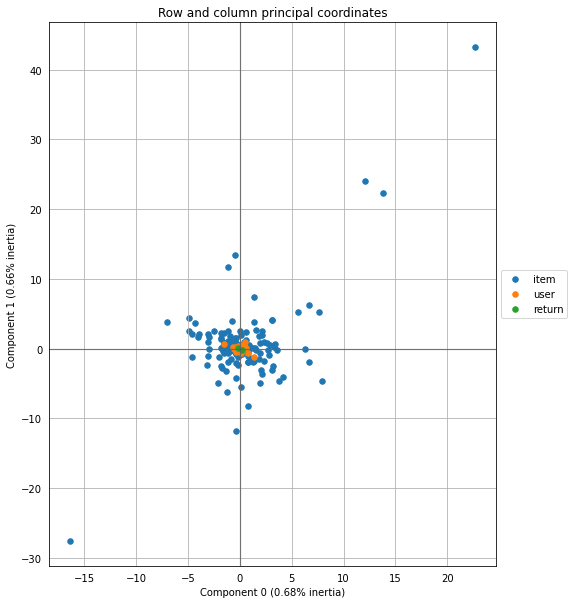

In [34]:
churn_mca = mca.fit(data_cat)

ax = churn_mca.plot_coordinates(
        X=data_cat,
        ax=None,
        figsize=(8, 10),
        show_row_points=False,
        row_points_size=0,
        show_row_labels=False,
        show_column_points=True,
        column_points_size=30,
        show_column_labels=False,
        legend_n_cols=1
               ).legend(loc='center left', bbox_to_anchor=(1, 0.5))